In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
#change to your datapath
# %cd /content/drive/MyDrive/EAI_2023_fall/StudentID_lab3

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from resnet18 import *
from tqdm import tqdm   # for progress bar

In [14]:
# Create SummaryWriter
writer = SummaryWriter("./tensorboard")

In [15]:
#檢查是否可用gpu
print(torch.cuda.is_available())

True


In [16]:
# Get cpu, gpu or mps device for training.
# for mac m1, use mps
# for intel or amd cpu, use cpu
# for gpu, use cuda
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [17]:
# setting parameter
EPOCH = 40
pre_epoch = 0
BATCH_SIZE = 128
lr = 0.05
# device = torch.device("cuda")

In [18]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std # in usual case, we don't have test dataset, we use train mean & std as test mean & std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified


Files already downloaded and verified
[0.49282825 0.48358223 0.44794032] [0.2470505  0.24352324 0.2617864 ]
[0.49282825 0.48358223 0.44794032] [0.2470505  0.24352324 0.2617864 ]


In [19]:
# data augmentation & normalization
transform_train = transforms.Compose([
    # data augmentation
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(train_mean, train_std)
])

# for test, we only need to normalize data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(train_mean, train_std)
])

In [20]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣
print("trainset length: ", len(trainset))
print("classes: ", trainset.classes)
image, label = trainset[0]
print("image shape: ", image.shape)
print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
trainset length:  50000
classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image shape:  torch.Size([3, 32, 32])
label:  6
train length:  45000
val length:  5000
test length:  10000


In [21]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    if epoch < 10:    # 0~9
        lr = 0.05
    elif epoch < 20:    # 10~19
        lr = 0.01
    elif epoch < 30:    # 20~29
        lr = 0.005
    else:               # 30~40
        lr = 0.001

    for param_group in optim.param_groups:
        param_group['lr'] = lr

In [22]:
#是否pretrain
net = ResNet(ResBlock).to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，採用L2正則化（權重衰減）
schecdular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5,last_epoch=-1)
# train
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in tqdm(range(pre_epoch, EPOCH)):
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            length = len(trainloader)
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index), train_outputs.data.shape is torch.Size([128, 10])
            # print(torch.max(train_outputs.data, 1)[1])
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()


        schecdular.step()
        writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        # adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])

        loss1 = sum1_loss / (i + 1) # i is equal to number of batches
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 每個epoch完用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)

                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()

            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)

            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()

        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))

  0%|          | 0/40 [00:00<?, ?it/s]


Epoch: 1
learning rate:  0.05
Train loss: 1.564 | Train acc: 0.431


  2%|▎         | 1/40 [00:11<07:14, 11.15s/it]

Val loss: 1.349 | Val acc: 0.512

Epoch: 2
learning rate:  0.05
Train loss: 1.005 | Train acc: 0.641


  5%|▌         | 2/40 [00:22<07:05, 11.19s/it]

Val loss: 1.086 | Val acc: 0.609

Epoch: 3
learning rate:  0.05
Train loss: 0.732 | Train acc: 0.743


  8%|▊         | 3/40 [00:33<06:53, 11.18s/it]

Val loss: 0.846 | Val acc: 0.702

Epoch: 4
learning rate:  0.05
Train loss: 0.573 | Train acc: 0.799


 10%|█         | 4/40 [00:44<06:42, 11.18s/it]

Val loss: 0.766 | Val acc: 0.738

Epoch: 5
learning rate:  0.05
Train loss: 0.459 | Train acc: 0.839


 12%|█▎        | 5/40 [00:55<06:30, 11.15s/it]

Val loss: 0.675 | Val acc: 0.766

Epoch: 6
learning rate:  0.05
Train loss: 0.370 | Train acc: 0.871


 15%|█▌        | 6/40 [01:07<06:19, 11.17s/it]

Val loss: 0.646 | Val acc: 0.785

Epoch: 7
learning rate:  0.05
Train loss: 0.288 | Train acc: 0.899


 18%|█▊        | 7/40 [01:18<06:08, 11.17s/it]

Val loss: 0.761 | Val acc: 0.775

Epoch: 8
learning rate:  0.05
Train loss: 0.235 | Train acc: 0.918


 20%|██        | 8/40 [01:29<05:56, 11.14s/it]

Val loss: 0.646 | Val acc: 0.797

Epoch: 9
learning rate:  0.05
Train loss: 0.190 | Train acc: 0.933


 22%|██▎       | 9/40 [01:40<05:45, 11.16s/it]

Val loss: 0.705 | Val acc: 0.796

Epoch: 10
learning rate:  0.025
Train loss: 0.155 | Train acc: 0.945


 25%|██▌       | 10/40 [01:51<05:34, 11.14s/it]

Val loss: 0.781 | Val acc: 0.772

Epoch: 11
learning rate:  0.025
Train loss: 0.046 | Train acc: 0.987


 28%|██▊       | 11/40 [02:02<05:23, 11.16s/it]

Val loss: 0.516 | Val acc: 0.852

Epoch: 12
learning rate:  0.025
Train loss: 0.009 | Train acc: 0.999


 30%|███       | 12/40 [02:13<05:12, 11.14s/it]

Val loss: 0.506 | Val acc: 0.859

Epoch: 13
learning rate:  0.025
Train loss: 0.004 | Train acc: 1.000


 32%|███▎      | 13/40 [02:25<05:00, 11.14s/it]

Val loss: 0.484 | Val acc: 0.862

Epoch: 14
learning rate:  0.025
Train loss: 0.003 | Train acc: 1.000


 35%|███▌      | 14/40 [02:36<04:48, 11.11s/it]

Val loss: 0.474 | Val acc: 0.864

Epoch: 15
learning rate:  0.025
Train loss: 0.003 | Train acc: 1.000


 38%|███▊      | 15/40 [02:47<04:37, 11.10s/it]

Val loss: 0.467 | Val acc: 0.862

Epoch: 16
learning rate:  0.025
Train loss: 0.003 | Train acc: 1.000


 40%|████      | 16/40 [02:58<04:26, 11.12s/it]

Val loss: 0.462 | Val acc: 0.864

Epoch: 17
learning rate:  0.025
Train loss: 0.002 | Train acc: 1.000


 42%|████▎     | 17/40 [03:09<04:16, 11.13s/it]

Val loss: 0.455 | Val acc: 0.863

Epoch: 18
learning rate:  0.025
Train loss: 0.002 | Train acc: 1.000


 45%|████▌     | 18/40 [03:20<04:04, 11.10s/it]

Val loss: 0.454 | Val acc: 0.864

Epoch: 19
learning rate:  0.025
Train loss: 0.002 | Train acc: 1.000


 48%|████▊     | 19/40 [03:31<03:52, 11.09s/it]

Val loss: 0.446 | Val acc: 0.864

Epoch: 20
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 50%|█████     | 20/40 [03:42<03:42, 11.11s/it]

Val loss: 0.449 | Val acc: 0.866

Epoch: 21
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 52%|█████▎    | 21/40 [03:53<03:30, 11.09s/it]

Val loss: 0.445 | Val acc: 0.866

Epoch: 22
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 55%|█████▌    | 22/40 [04:04<03:20, 11.11s/it]

Val loss: 0.443 | Val acc: 0.865

Epoch: 23
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 57%|█████▊    | 23/40 [04:15<03:08, 11.08s/it]

Val loss: 0.444 | Val acc: 0.866

Epoch: 24
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 60%|██████    | 24/40 [04:27<02:57, 11.11s/it]

Val loss: 0.441 | Val acc: 0.865

Epoch: 25
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 62%|██████▎   | 25/40 [04:38<02:46, 11.10s/it]

Val loss: 0.440 | Val acc: 0.866

Epoch: 26
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 65%|██████▌   | 26/40 [04:49<02:35, 11.12s/it]

Val loss: 0.436 | Val acc: 0.865

Epoch: 27
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 68%|██████▊   | 27/40 [05:00<02:24, 11.14s/it]

Val loss: 0.439 | Val acc: 0.866

Epoch: 28
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 70%|███████   | 28/40 [05:11<02:14, 11.19s/it]

Val loss: 0.437 | Val acc: 0.866

Epoch: 29
learning rate:  0.0125
Train loss: 0.002 | Train acc: 1.000


 72%|███████▎  | 29/40 [05:23<02:03, 11.20s/it]

Val loss: 0.438 | Val acc: 0.864

Epoch: 30
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 75%|███████▌  | 30/40 [05:34<01:52, 11.22s/it]

Val loss: 0.440 | Val acc: 0.864

Epoch: 31
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 78%|███████▊  | 31/40 [05:45<01:41, 11.23s/it]

Val loss: 0.436 | Val acc: 0.866

Epoch: 32
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 80%|████████  | 32/40 [05:56<01:29, 11.23s/it]

Val loss: 0.436 | Val acc: 0.866

Epoch: 33
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 82%|████████▎ | 33/40 [06:07<01:18, 11.21s/it]

Val loss: 0.440 | Val acc: 0.865

Epoch: 34
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 85%|████████▌ | 34/40 [06:19<01:07, 11.22s/it]

Val loss: 0.437 | Val acc: 0.864

Epoch: 35
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 88%|████████▊ | 35/40 [06:30<00:56, 11.22s/it]

Val loss: 0.436 | Val acc: 0.865

Epoch: 36
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 90%|█████████ | 36/40 [06:41<00:44, 11.18s/it]

Val loss: 0.437 | Val acc: 0.865

Epoch: 37
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 92%|█████████▎| 37/40 [06:52<00:33, 11.20s/it]

Val loss: 0.437 | Val acc: 0.865

Epoch: 38
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 95%|█████████▌| 38/40 [07:03<00:22, 11.18s/it]

Val loss: 0.437 | Val acc: 0.864

Epoch: 39
learning rate:  0.00625
Train loss: 0.002 | Train acc: 1.000


 98%|█████████▊| 39/40 [07:15<00:11, 11.19s/it]

Val loss: 0.437 | Val acc: 0.864

Epoch: 40
learning rate:  0.003125
Train loss: 0.002 | Train acc: 1.000


100%|██████████| 40/40 [07:26<00:00, 11.16s/it]

Val loss: 0.437 | Val acc: 0.864


Test loss: 0.449 | Test acc: 0.866


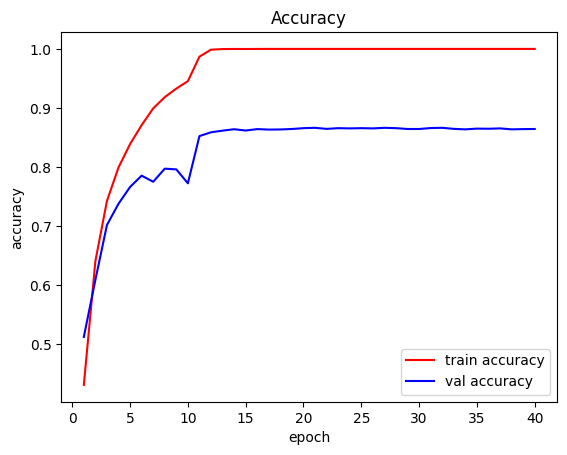

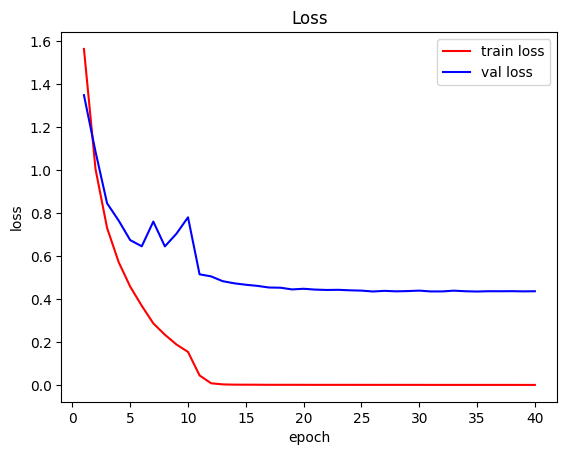

In [23]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy")
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim(0.6, 1.1)
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss")
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()